In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.stats import bayesian_blocks

import cosmology
from hbtp import HBTReader

from src import read

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
savefig = True

In [3]:
plt.style.use('paper')

### Analysis parameters

In [4]:
snap = 122
NFW_f = 0.02

In [5]:
zs = pd.read_csv(
    "./data/redshift_list.txt", delimiter=" ", header=None, names=["snap", "z"]
).set_index("snap")

### Halo mass function & binning

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [6]:
def read_haloes(grav, snap):
    hs = HBTReader("./data/%s/subcat" % grav).LoadHostHalos(snap)
    hs["M200Crit"] = 1e10 * hs["M200Crit"]
    hs = hs[hs["M200Crit"] >= 1000 * 1.52315180e8]
    #     hs = hs[hs["CenterOffset"] >= 0.07]
    return hs


def bin_haloes(haloes, bin_column, bin_edges, bin_transform=lambda x: x):
    hs = np.lib.recfunctions.append_fields(
        haloes,
        "bin",
        np.digitize(bin_transform(haloes[bin_column]), bin_edges, right=True),
        usemask=False,
    )
    hs = hs[hs["bin"] != 0]
    return hs


def filter_haloes(haloes):
    return (np.log10(haloes["M200Crit"]) > 11.52) & (
        np.log10(haloes["M200Crit"]) < 11.525
    )

In [7]:
haloes_gr = read_haloes("GR_b64n512", 122)
haloes_f6 = read_haloes("fr6_b64n512", 122)

In [8]:
haloes_gr = haloes_gr[filter_haloes(haloes_gr)]
haloes_f6 = haloes_f6[filter_haloes(haloes_f6)]

In [9]:
print(haloes_gr.size)
print(haloes_f6.size)

25
19


### Density profile

In [10]:
def fit_nfw(xs, ps, idx):
    def f(x, c):
        return np.log10(cosmology.nfw.m(np.power(10.0, x), c))

    popt, pcov = curve_fit(
        f, xs[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx], [10.0]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(xs[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 1 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 1 - 2 * np.log(L)

    return L, AIC, BIC, chi2, popt


def fit_einasto(xs, ps, idx):
    def f(x, c, a):
        return np.log10(cosmology.einasto.m(np.power(10.0, x), c, a))

    popt, pcov = curve_fit(
        f, xs[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx], [10.0, 1.0]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(xs[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 2 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 2 - 2 * np.log(L)

    return L, AIC, BIC, chi2, popt

In [11]:
def halo_profiles(hs):
    ps = hs["Profile"]
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    xs = np.linspace(-2.0, 0.0, 20)
    xmax = 0.8
    idx = np.where((np.power(10, xs) < xmax) & (np.power(10, xs) > xmin))

    c_nfw = fit_nfw(xs, ps, idx)[-1][0]
    rho_s_nfw = np.log10(cosmology.nfw.rho_enc(1.0 / c_nfw, c_nfw))

    c_ein, a_ein = fit_einasto(xs, ps, idx)[-1]
    rho_s_ein = np.log10(cosmology.einasto.rho_enc(1.0 / c_ein, c_ein, a_ein))

    return (
        np.log10(np.cumsum(ps, axis=1)),
        xs,
        np.log10(np.median(np.cumsum(ps, axis=1), axis=0)),
        idx,
        c_nfw,
        rho_s_nfw,
        c_ein,
        a_ein,
        rho_s_ein,
    )

In [12]:
def plot_profiles(ax, ax_res, haloes):
    ps, xs, p, idx, c_nfw, rho_s_nfw, c_ein, a_ein, rho_s_ein = halo_profiles(haloes)
    col_median = "k"
    col_nfw = "C0"
    col_ein = "C1"

    for _p in ps:
        ax.plot(xs, _p, color="silver", zorder=0)

    ax.plot(
        xs[idx],
        p[idx],
        color=col_median,
        linestyle="--",
        linewidth=1,
        label="median mass profile",
    )
    ax_res.plot(
        xs[idx],
        np.zeros_like(p[idx]),
        color=col_median,
        linestyle="--",
        linewidth=1,
        zorder=1,
    )
    ax.plot(
        xs[idx],
        np.log10(cosmology.nfw.m(np.power(10.0, xs), c_nfw)[idx]),
        color=col_nfw,
        linestyle="-",
        linewidth=1,
        label="NFW profile",
    )
    ax_res.plot(
        xs[idx],
        np.log10(cosmology.nfw.m(np.power(10.0, xs), c_nfw)[idx]) - p[idx],
        color=col_nfw,
        linestyle="-",
        linewidth=1,
        zorder=3,
    )
    ax.axvline(
        np.log10(1.0 / c_nfw),
        color=col_nfw,
        linestyle="--",
        linewidth=1,
        label="$r_{-2}$ of NFW profile",
    )
    ax.plot(
        xs[idx],
        np.log10(cosmology.einasto.m(np.power(10.0, xs), c_ein, a_ein)[idx]),
        color=col_ein,
        linestyle="-",
        linewidth=1,
        label="Einasto profile",
    )
    ax_res.plot(
        xs[idx],
        np.log10(cosmology.einasto.m(np.power(10.0, xs), c_ein, a_ein)[idx]) - p[idx],
        color=col_ein,
        linestyle="-",
        linewidth=1,
    )
    ax_res.axvline(
        np.log10(1.0 / c_nfw), color=col_nfw, linestyle="--", zorder=4, linewidth=1
    )

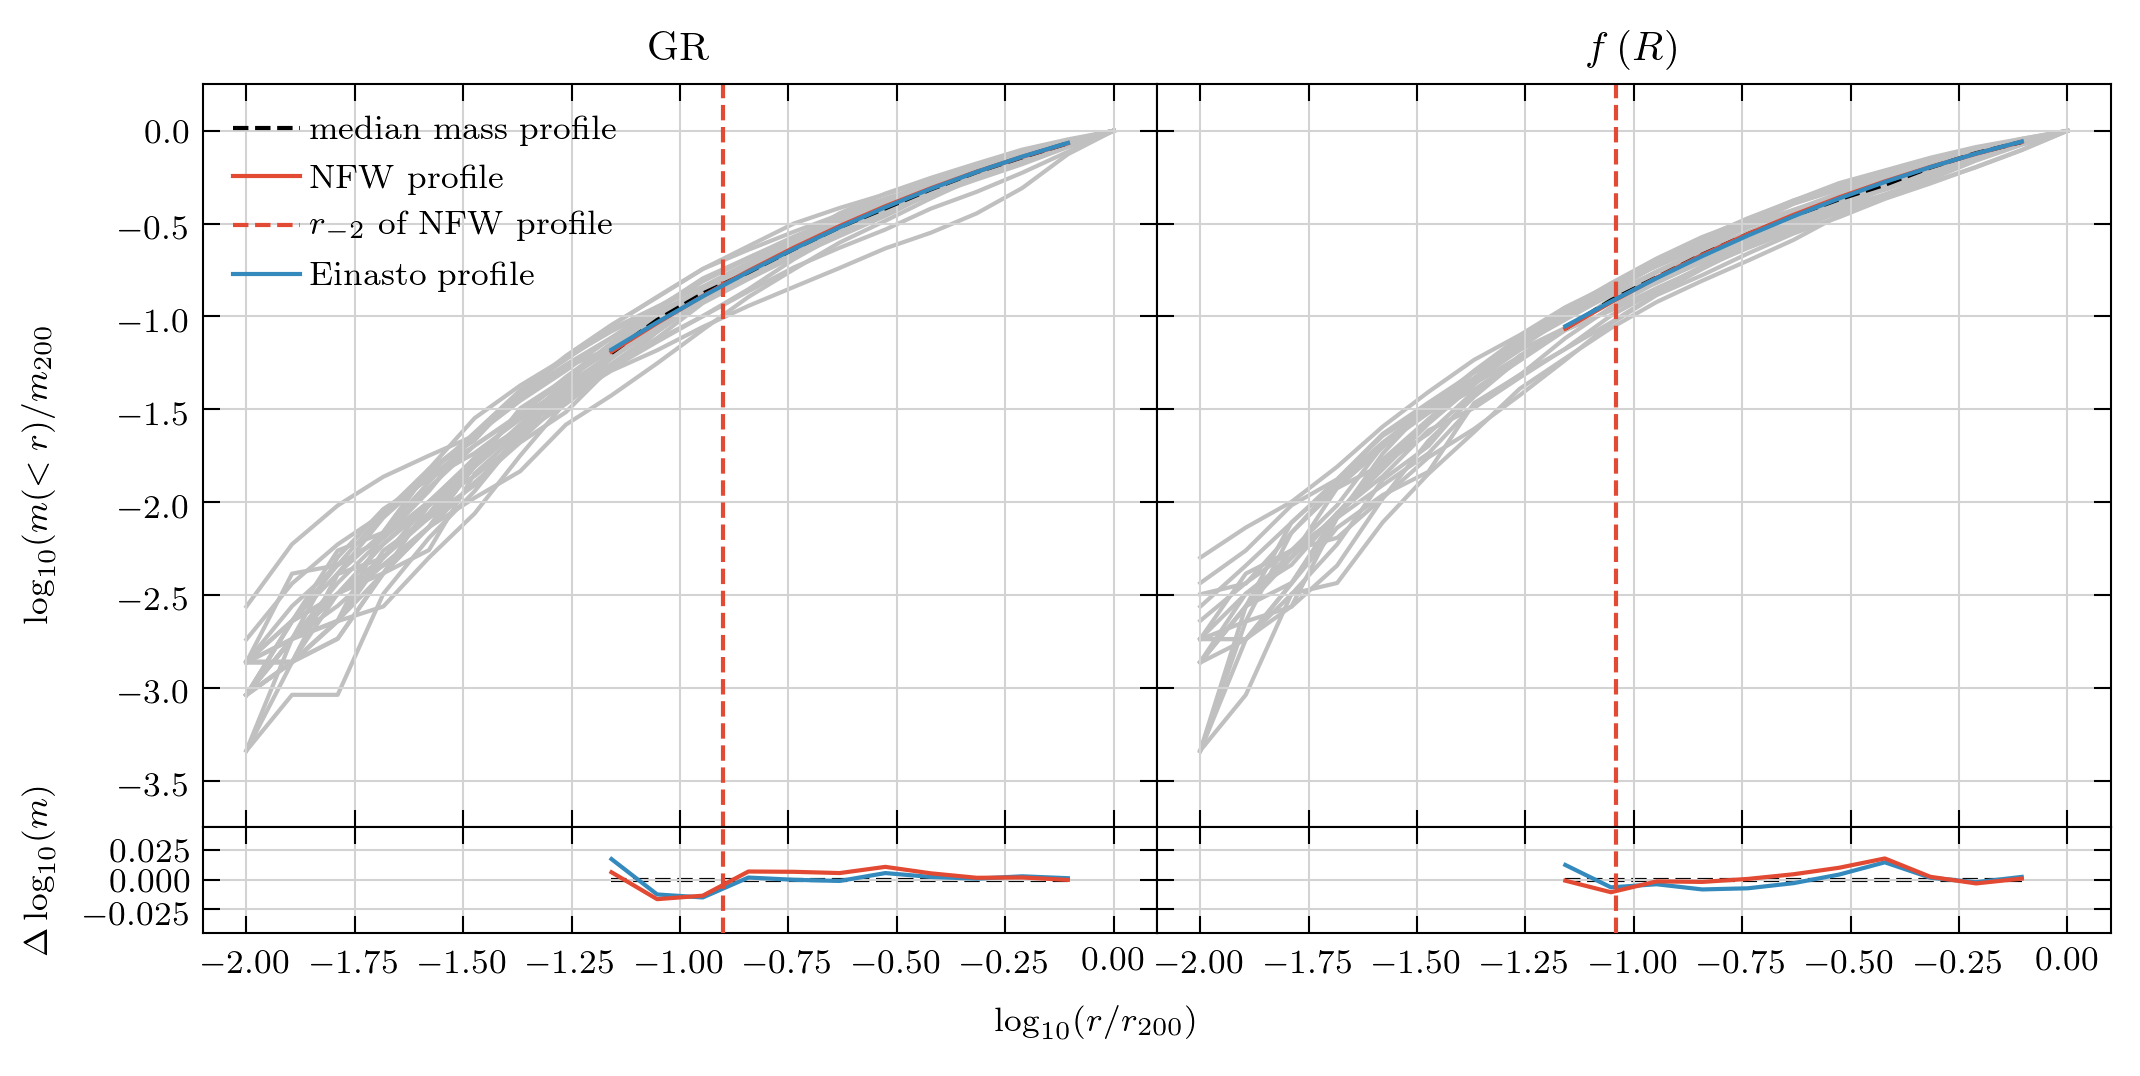

In [13]:
fig = plt.figure(figsize=[7.0, 3.4])
grid = plt.GridSpec(8, 2, hspace=0.0, wspace=0.0)

ax = [
    [
        fig.add_subplot(grid[0:-1, 0], xlim=[-2.1, 0.1], ylim=[-3.75, 0.25]),
        fig.add_subplot(grid[-1, 0], xlim=[-2.1, 0.1], ylim=[-0.045, 0.045]),
    ],
    [
        fig.add_subplot(
            grid[0:-1, 1], xlim=[-2.1, 0.1], ylim=[-3.75, 0.25], yticklabels=[]
        ),
        fig.add_subplot(
            grid[-1, 1], xlim=[-2.1, 0.1], ylim=[-0.045, 0.045], yticklabels=[]
        ),
    ],
]

fig.text(0.5, -0.025, r"$\log_{10}(r / r_{200})$", ha="center")
fig.text(0.0, 0.65, r"$\log_{10}(m(<r) / m_{200}$", ha="center", rotation="vertical")
fig.text(0.0, 0.2, r"$\Delta\log_{10}(m)$", ha="center", rotation="vertical")

plot_profiles(ax[0][0], ax[0][1], haloes_gr)
plot_profiles(ax[1][0], ax[1][1], haloes_f6)

ax[0][0].set_title("GR")
ax[1][0].set_title(r"$f\left(R\right)$")

ax[0][0].legend(loc="upper left")

fig.tight_layout()

if savefig:
    fig.savefig("./plots/prof_%02d.pdf" % snap)

In [14]:
ps_gr, xs_gr, p_gr, idx_gr, c_nfw_gr, rho_s_nfw_gr, c_ein_gr, a_ein_gr, rho_s_ein_gr = halo_profiles(haloes_gr)
ps_f6, xs_f6, p_f6, idx_f6, c_nfw_f6, rho_s_nfw_f6, c_ein_f6, a_ein_f6, rho_s_ein_f6 = halo_profiles(haloes_f6)

### Collapsed Mass History

In [15]:
def F_nfw(c):
    return  cosmology.nfw.m(1.0 / c, c)

def F_ein(c, a):
    return cosmology.einasto.m(1.0 / c, c, a)

In [16]:
def halo_histories(grav, snap, ids, F):
    ms = np.array(
        pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))
        .set_index("HaloId")
        .fillna(0.0)
        .loc[ids]
        .dropna(),
        dtype=float,
    )
    ms = np.divide(ms.T, ms[:, -1]).T
    m = np.median(ms, axis=0)

    zs = read.snaps()
    rho = cosmology.rho_c(
        np.array(
            [
                zs[zs["Snapshot"] == s][0]["Redshift"]
                for s in np.arange(1 + snap - ms.shape[1], 1 + snap)
            ]
        )
    ) / cosmology.rho_c(zs[zs["Snapshot"] == snap][0]["Redshift"])

    m_f = F * m[-1]
    y1, y2 = m[m > m_f][0], m[m < m_f][-1]
    x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
    rho_f = (np.log10(x1 / x2) / np.log10(y1 / y2)) * (np.log10(m_f / y1)) + np.log10(
        x1
    )

    return np.log10(ms), np.log10(rho), np.log10(m), rho_f, F

In [17]:
F_nfw(c_nfw_gr)

0.1480206636800824

In [18]:
F_ein(c_ein_gr, a_ein_gr)

0.1553881833648119

In [19]:
F_nfw(c_nfw_f6)

0.12308717078965578

In [20]:
F_ein(c_ein_f6, a_ein_f6)

0.121948265051254

In [21]:
def plot_histories(ax, grav, snap, ids, F):
    ms, rho, m, rho_f, F = halo_histories(grav, snap, ids, F)

    for _m in ms:
        ax.plot(rho, _m, color="silver", zorder=0)

    ax.plot(
        rho,
        m,
        color="k",
        linestyle="-",
        linewidth=1,
        label="median mass history",
    )
    ax.axvline(
        rho_f,
        color="C0",
        linestyle="--",
        linewidth=1,
        label="formation threshold",
    )
    ax.axhline(np.log10(F), color="C0", linestyle="--", zorder=1, linewidth=1)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


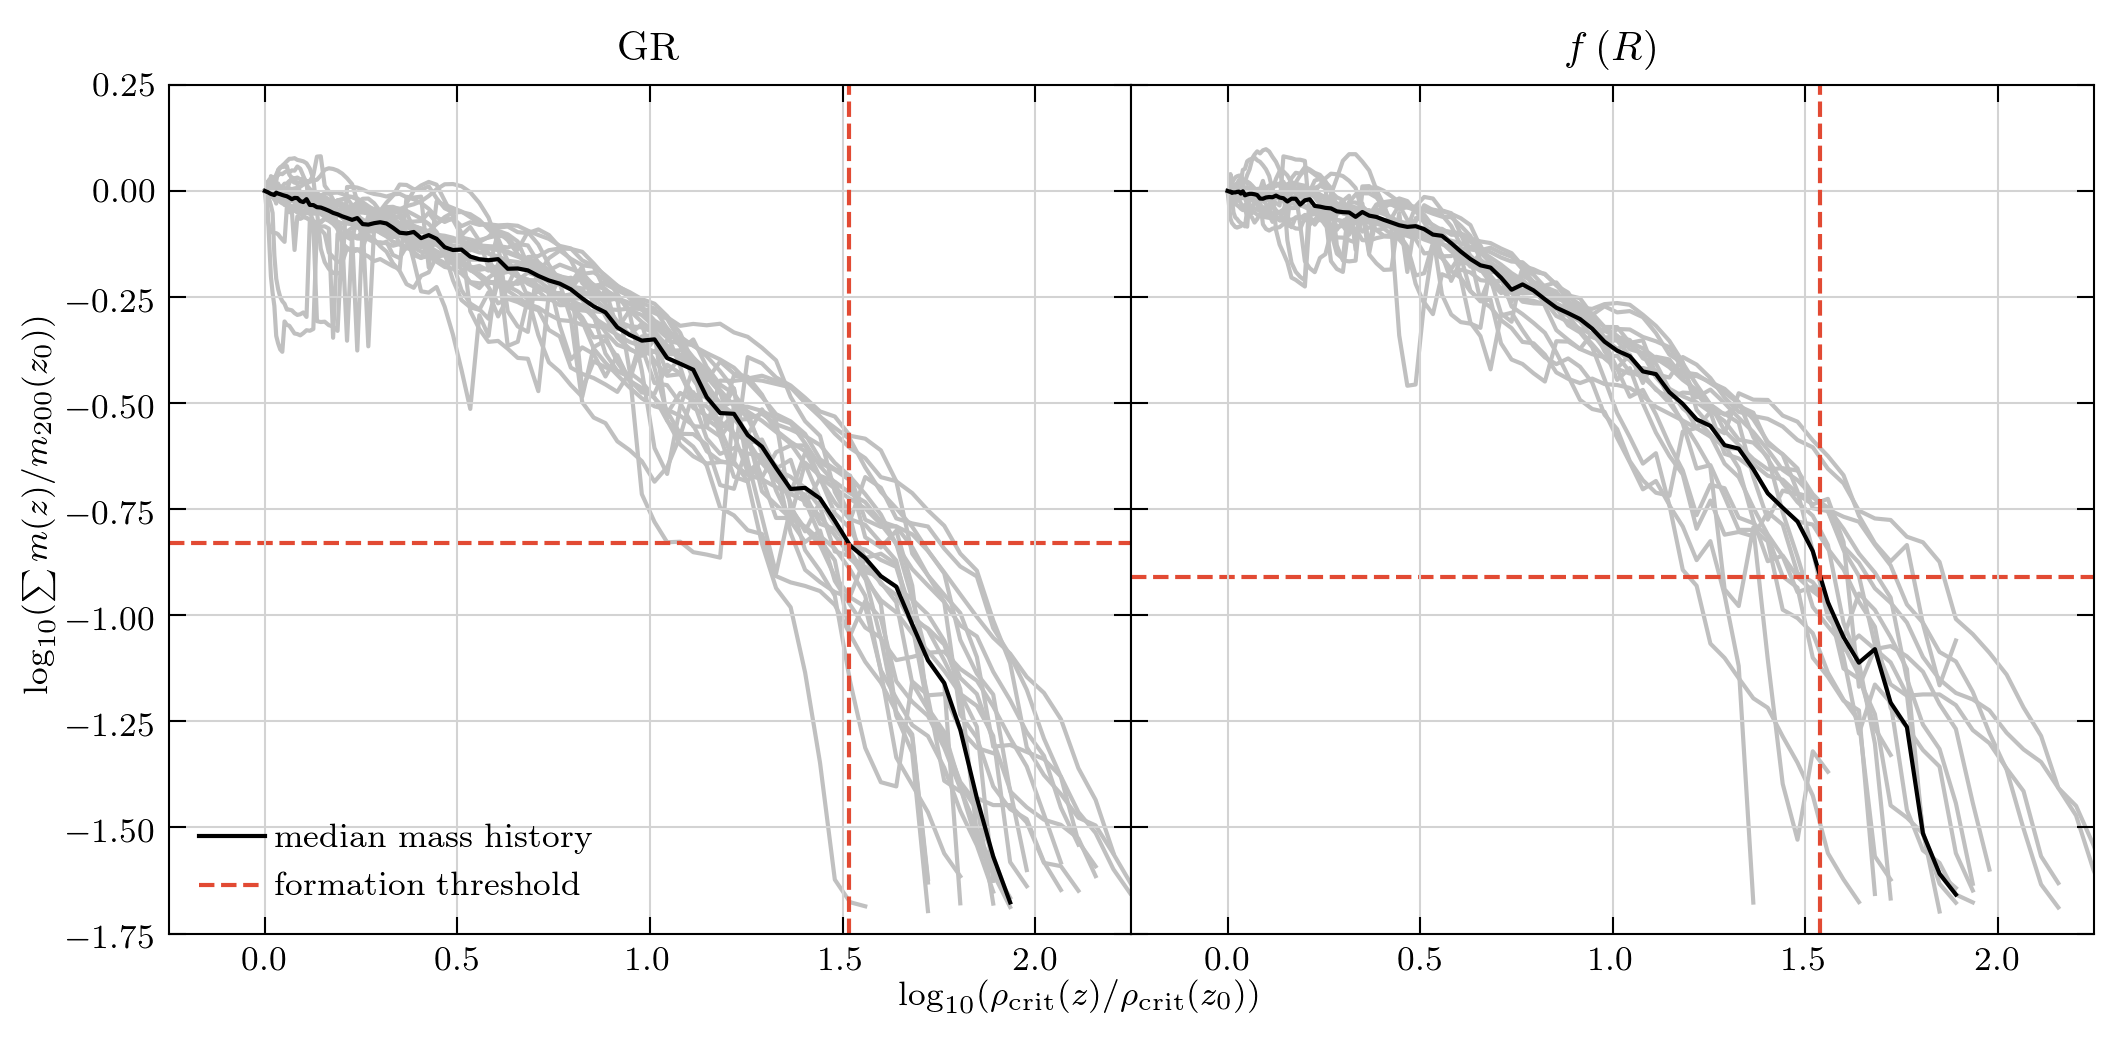

In [22]:
fig = plt.figure(figsize=[7.0, 3.4])
grid = plt.GridSpec(1, 2, hspace=0.0, wspace=0.0)

ax = [
    fig.add_subplot(
        grid[0],
        title="GR",
        xlim=[-0.25, 2.25],
        ylim=[-1.75, 0.25],
    ),
    fig.add_subplot(
        grid[1],
        title=r"$f\left(R\right)$",
        xlim=[-0.25, 2.25],
        ylim=[-1.75, 0.25],
        yticklabels=[],
    ),
]

fig.text(
    0.5,
    0.0,
    r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$",
    ha="center",
)
fig.text(
    0.0,
    0.5,
    r"$\log_{10}(\sum m(z) / m_{200}(z_0))$",
    va="center",
    rotation="vertical",
)

plot_histories(ax[0], "GR_b64n512", 122, haloes_gr["HaloId"], F_nfw(c_nfw_gr))
plot_histories(ax[1], "fr6_b64n512", 122, haloes_f6["HaloId"], F_nfw(c_nfw_f6))

ax[0].legend()

fig.tight_layout()

if savefig:
    fig.savefig("./plots/cmh_f%03d_%02d.pdf" % (100 * NFW_f, snap))